In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import tensorflow as tf
import scipy.io as sio
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from matplotlib import pyplot

Using TensorFlow backend.


In [0]:
%cd /content/drive/My\ Drive/
training_data = sio.loadmat('train_32x32.mat')
testing_data = sio.loadmat('test_32x32.mat')

/content/drive/My Drive


In [0]:
X_tr, y_tr = training_data['X'], training_data['y']
X_te, y_te = testing_data['X'], testing_data['y']

In [0]:
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = 10
no_classes=11

In [0]:
X_tr = np.transpose(X_tr,(3,0,1,2))
X_te = np.transpose(X_te,(3,0,1,2))

In [0]:

X_tr = X_tr.astype('float32') / 255
X_te = X_te.astype('float32') / 255

In [0]:

y_tr = to_categorical(y_tr)
y_te = to_categorical(y_te)

In [0]:
print('Training set', X_tr.shape, y_tr.shape)
print('Test set', X_te.shape, y_te.shape)

Training set (73257, 32, 32, 3) (73257, 11)
Test set (26032, 32, 32, 3) (26032, 11)


In [0]:
from keras import backend as K

def rec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def pre(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = pre(y_true, y_pred)
    recall = rec(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
#VGG16 model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(VGG16(include_top=True, weights=None, input_shape=X_tr[0].shape, pooling='max', classes=no_classes))
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',      
              metrics=['acc',f1,pre, rec])

In [0]:
#it shows the architecture of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 11)                33642315  
Total params: 33,642,315
Trainable params: 33,642,315
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_history = model.fit(X_tr, y_tr, batch_size=200, epochs=10, validation_split = 0.1)

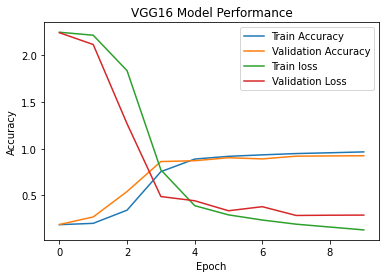

In [0]:
#Here we plot the performance of the model on the training and validation data.
plt.plot(model_history.history["acc"])
plt.plot(model_history.history['val_acc'])
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train Accuracy","Validation Accuracy","Train loss","Validation Loss"])
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [0]:
#Here we calculate the accuracy of the model
score = model.evaluate(X_te, y_te, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.415358730697373
Test accuracy: 0.9397280216217041


In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_te, y_te, verbose=0)

In [0]:
print(loss)
print(accuracy)
print(f1_score)
print(precision)
print(recall)

0.415358730697373
0.9397280216217041
0.9406531453132629
0.9424850344657898
0.938882052898407


In [0]:
res_test = model.predict(X_te)

In [0]:
res_test = pd.DataFrame({'true':np.argmax(y_te, axis=1), 'guess':np.argmax(res_test, axis=1), 'trust':np.max(res_test, axis=1)})
res_test.head(10)

,true,guess,trust
0,5,5,0.993704
1,2,2,0.995610
2,1,1,0.999996
3,10,10,0.993434
4,6,6,0.956039
5,1,1,0.999817
6,9,9,0.995883
7,1,1,1.000000
8,1,1,0.999993
9,8,8,0.999999


In [0]:
errors = res_test[res_test.true != res_test.guess].sort_values('trust', ascending=False)
errors.head(10)

,true,guess,trust
15700,3,10,1.000000
8251,8,1,1.000000
7953,2,1,1.000000
12652,2,1,1.000000
6492,1,3,0.999998
1317,1,5,0.999998
1318,5,10,0.999995
22882,8,4,0.999992
1933,8,1,0.999974
11844,5,1,0.999973


In [0]:
print('Percentage of error %4.2f %%' % (100 * len(errors)/len(X_te)))

Percentage of error 6.29 %


Image 16000
Model says it is a 2 while it is a 2
Stats are [[8.2031043e-08 1.2527689e-03 9.9537945e-01 1.0992278e-03 4.5570027e-04
  5.9784675e-04 2.9161619e-04 2.8193256e-04 2.4634533e-04 2.0914337e-04
  1.8599858e-04]]


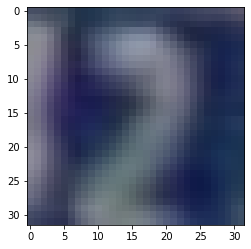

In [0]:
i = 16000 #1318
res = model.predict(X_te[i][None,:,:])  # None permet d'augmenter la dimension du tableau (sans on a un message d'erreur clair)
print("Image", i)
print(f"Model says it is a {np.argmax(res)} while it is a {np.argmax(y_te[i])}")
print("Stats are", np.array(res))
plt.imshow(X_te[i])

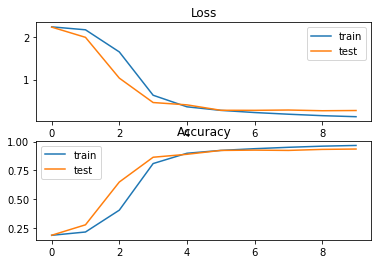

In [0]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(model_history.history['loss'], label='train')
pyplot.plot(model_history.history['val_loss'], label='validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(model_history.history['acc'], label='train')
pyplot.plot(model_history.history['val_acc'], label='Validation')
pyplot.legend()
pyplot.show()
